## Sentiment analysis with NSMC (text classification) 

### 1. What is sentiment analysis?

* Natural Language Processing, Text Analysis, Computational Lingustics, and biometrics are used to find out the author's intention or information hidden in the text.


* It is also called Opinion Mining, Sentiment Mining, and Subjectivity Analysis.


* The early methods were tried a lot to find the polarity of the text. A typical example is the case of dividing into <b>positive/negative</b>.


* Sentiment analysis is largely divided into a knowledge-based approach and a machine learning-based approach.

> Knowledge-based is a method that imports data that has already been evaluated by human experts using known phrases, endings, and idiomatic expressions.

> ML-based approach has supervised and unsupervised methods. Recently, as pretrained language models have been developed by leaps and bounds, the performance of unsupervised methods has increased, but supervised is still superior in terms of performance.

### 2. What is text classification?

* It is a method of literally classifying text represented in vector form.


* SVMs were the most commonly used until DNNs improved performance by a huge percentage.


* Currently, CNN and LSTM are the most popular classification models.


* In practice, the task of text classification largely includes most NLP downstream tasks.


* For example, if we train a question-answer pair using a Siamese Network, the classification problem becomes one of "did I choose the right answer for a particular question (0 / 1)".

### 3. Analyze NSMC sentiment with scikit-learn

In [1]:
def read_documents(filename):
    with open(filename, encoding='utf-8') as f:
        documents = [line.split('\t') for line in f.read().splitlines()]
        documents = documents[1:]
        
    return documents
    
train_docs = read_documents("/Users/shim/dl-python-SentimentAnalysis/data/ratings_train.txt")
test_docs = read_documents("/Users/shim/dl-python-SentimentAnalysis/data/ratings_test.txt")

In [2]:
print(len(train_docs))
print(len(test_docs))

150000
50000


In [3]:
def text_cleaning(doc):
    # A function to remove letters except Korean.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    return doc

def define_stopwords(path):
    
    SW = set()
    # How to add a boolean 1.
    # SW.add("there is")
    
    # How to add a stopword 2.
    # Add directly to stopwords-en.txt
    with open(path) as f:
        for word in f:
            SW.add(word)
            
    return SW

def text_tokenizing(doc):
    return [word for word in mecab.morphs(doc) if word not in SW and len(word) > 1]
    
    # extract only nouns for a wordcloud.
    #return [word for word in mecab.nouns(doc) if word not in SW and len(word) > 1]

* Tokenize the imported data with part-of-speech tags.

In [6]:
from konlpy.tag import Mecab
from konlpy.tag import Okt
import json
import os
import re
from pprint import pprint

#okt = Okt()
mecab = Mecab()

SW = define_stopwords("/Users/shim/dl-python-SentimentAnalysis/Konlpy/stopwords-ko.txt")

if os.path.exists('train_docs.json'):
    with open("train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
else:
    # Create 2 versions of train_data. 1) With cleaning   2) Without cleaning

    train_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in train_docs if text_tokenizing(text_cleaning(line[1]))]
    #train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]
    
    with open("train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        
if os.path.exists('test_docs.json'):
    with open("test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
else:
    test_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in test_docs if text_tokenizing(text_cleaning(line[1]))]
    #test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    with open("test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

pprint(train_data[0])
pprint(test_data[0])

[['진짜', '짜증', '네요', '목소리'], '0']
[['평점', '나쁘', '지만', '짜리', '더더욱', '아니', '잖아'], '0']


In [7]:
print(train_data[:3])
print(len(train_docs)- len(train_data))
print(len(test_docs)- len(test_data))


[[['진짜', '짜증', '네요', '목소리'], '0'], [['포스터', '보고', '초딩', '영화', '오버', '연기', '조차', '가볍', '구나'], '1'], [['너무', '밓었다그래서보는것을추천한다'], '0']]
3535
1127


* Check basic information to analyze the data.

* Perform preprocessing using the NLTK library.

In [8]:
import nltk

total_tokens = [token for doc in train_data for token in doc[0]]
print(len(total_tokens))

1137741


In [10]:
text = nltk.Text(total_tokens, name='NMSC')
print(len(set(text.tokens)))
pprint(text.vocab().most_common(10))

48124
[('영화', 57630),
 ('는데', 11407),
 ('너무', 11013),
 ('정말', 9779),
 ('으로', 9314),
 ('재밌', 8989),
 ('네요', 8977),
 ('지만', 8737),
 ('진짜', 8327),
 ('에서', 8069)]


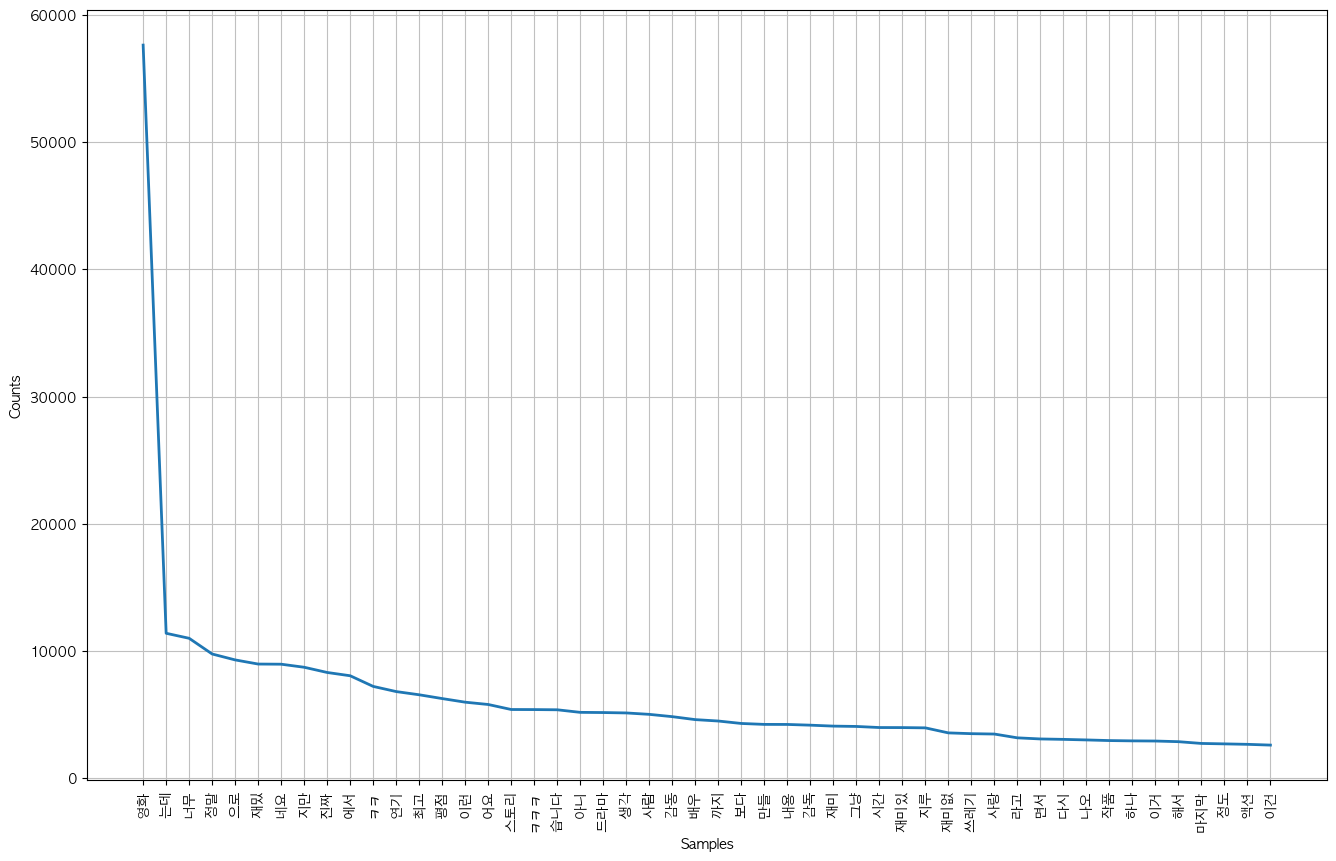

<Axes: xlabel='Samples', ylabel='Counts'>

In [11]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(16, 10))
text.plot(50)

In [13]:
# a function that combines multiple lists into one
def list_to_str(List): 
    return " ".join(List)

### 4. Classification of nsmc with Linear Classifier and Support Vector Machine

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import numpy as np

#Unifying the shape of your dataset for training
train_x = [list_to_str(doc) for doc, _ in train_data]
test_x = [list_to_str(doc) for doc, _ in test_data]
train_y = [label for _, label in train_data]
test_y = [label for _, label in test_data]

print(len(train_x), len(train_y))
print("For %d train data" % len(train_x))
print(len(test_x), len(test_y))

#1. Perceptron linear classifier
learner = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                         alpha=1e-4, random_state=42,
                         max_iter=100))
])

#2. SVM with linear kernel
learner2 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='linear'))
    
])

#3. SVM with polynomial kernel
learner3 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='poly', degree=8))
])

#4. SVM with Radius Basic Function kernel
learner4 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='rbf'))
])

#5. SVM with Radius sigmoid kernel
learner5 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='sigmoid'))
])

#6. SVM with Naive Bayes Classifier (Multinomial Ver.)
learner6 = Pipeline([
    ('vect', CountVectorizer()),
    ('mb', MultinomialNB())
])

#learning models
classifier = learner

classifier.fit(train_x, train_y)
train_predict = classifier.predict(train_x)
train_accuracy = np.mean(train_predict == train_y)

test_predict = classifier.predict(test_x)
test_accuracy = np.mean(test_predict == test_y)

# TEST and Measure performance
print("For %d test data" % len(test_x))

print("Training Accuracy : %.2f" % train_accuracy)
print("Test Accuracy : %.2f" % test_accuracy)

146465 146465
For 146465 train data
48873 48873
For 48873 test data
Training Accuracy : 0.85
Test Accuracy : 0.77


### < Experimental results 1 >

#### Train a linear classifier to measure test accuracy. (learner)

1. extract nouns only : 0.51
2. no preprocessing and stemming : 0.67
3. preprocessing and stemming : 0.76

-----Using only top 500 features --------
4. 3 + all features : 0.77

### < Experimental results >

#### Train an SVM classifier to measure test accuracy. (learner2)

1. extract nouns only : 0.53
2. no preprocessing and stemming : 0.72
3. preprocessing and stemming : 0.77

-----Using only top 500 features so far--------
4. 3 + all features : 0.81

### < Conclusion >

1. extracting only nouns does not provide clear information on the classification problem of NSMC data. 

2. There is a difference in performance with and without preprocessing. Since there are many special characters in NSMC data, excluding special characters makes the tokens more canonical (text normalization). 

3. It is more performant to use all dimension sources rather than truncating the top 500 with high frequency. 

4. Comparison performance Countvectorizer vs TF-IDF Vectorizer

5. Tuning hyperparameters for better performance